#Exploratory Data Analysis, Stratified sampling, Polynomial regression

**This notebook shows exploratory data analysis, checks whether stratified sampling helps and also explores polynomial regression**

In [ ]:
#@title Common Imports { display-mode: "form" }
#adding required imports
import numpy as np
import os
import matplotlib as mpl
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.metrics import r2_score
import xgboost as xg
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression

In [ ]:
#@title Read Data { display-mode: "form" }
#read data from drive
from google.colab import drive

drive.mount('/content/drive/')
path = '/content/drive/Shareddrives/DA224-O/mp_1/data/SeoulBikeData_MP1.csv'
df = pd.read_csv(path)
df.head()

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


,Unnamed: 0,Date,Rented Bike Count,Hour,Temperature(C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
0,0,01/12/17,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,1,01/12/17,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,2,01/12/17,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,3,01/12/17,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,4,01/12/17,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes


In [ ]:
#@title Data Information { display-mode: "form" }
df.info() #temperature has the missing data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Unnamed: 0                8760 non-null   int64  
 1   Date                      8760 non-null   object 
 2   Rented Bike Count         8760 non-null   int64  
 3   Hour                      8760 non-null   int64  
 4   Temperature(C)            8260 non-null   float64
 5   Humidity(%)               8760 non-null   int64  
 6   Wind speed (m/s)          8760 non-null   float64
 7   Visibility (10m)          8760 non-null   int64  
 8   Dew point temperature(C)  8760 non-null   float64
 9   Solar Radiation (MJ/m2)   8760 non-null   float64
 10  Rainfall(mm)              8760 non-null   float64
 11  Snowfall (cm)             8760 non-null   float64
 12  Seasons                   8760 non-null   object 
 13  Holiday                   8760 non-null   object 
 14  Function

In [ ]:
#@title Describe data { display-mode: "form" }
df.describe()

,Unnamed: 0,Rented Bike Count,Hour,Temperature(C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm)
count,8760.000000,8760.000000,8760.000000,8260.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000
mean,4379.500000,704.602055,11.500000,12.877349,58.226256,1.724909,1436.825799,4.073813,0.569111,0.148687,0.075068
std,2528.938512,644.997468,6.922582,11.957556,20.362413,1.036300,608.298712,13.060369,0.868746,1.128193,0.436746
min,0.000000,0.000000,0.000000,-17.500000,0.000000,0.000000,27.000000,-30.600000,0.000000,0.000000,0.000000
25%,2189.750000,191.000000,5.750000,3.500000,42.000000,0.900000,940.000000,-4.700000,0.000000,0.000000,0.000000
50%,4379.500000,504.500000,11.500000,13.750000,57.000000,1.500000,1698.000000,5.100000,0.010000,0.000000,0.000000
75%,6569.250000,1065.250000,17.250000,22.500000,74.000000,2.300000,2000.000000,14.800000,0.930000,0.000000,0.000000
max,8759.000000,3556.000000,23.000000,39.400000,98.000000,7.400000,2000.000000,27.200000,3.520000,35.000000,8.800000


In [ ]:
#@title Data Shape { display-mode: "form" }
df.shape

(8760, 15)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff1948215d0>,
      dtype=object)

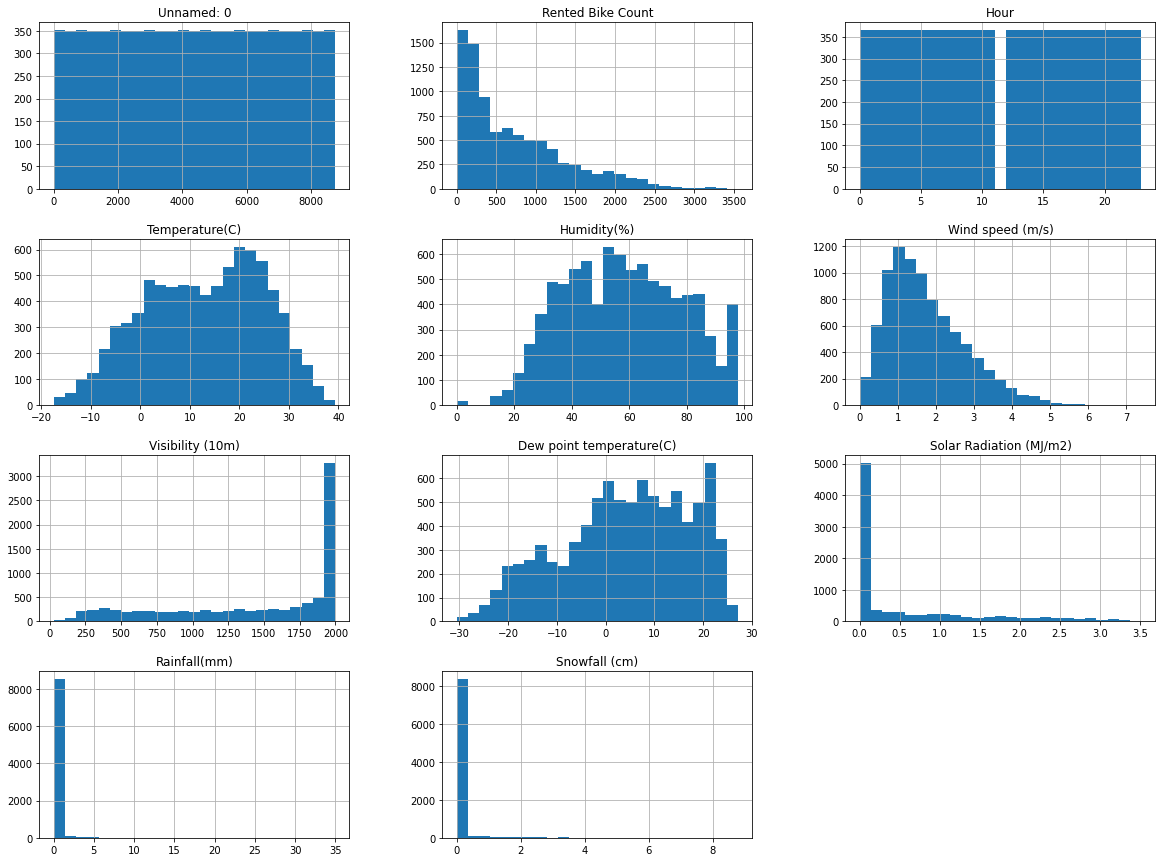

In [ ]:
#@title Data Histogram { display-mode: "form" }
df.hist(bins=25,figsize=(20,15))

In [ ]:
#@title Datatype conversion, feature addition { display-mode: "form" }
#drop unused column
df = df.drop(columns=['Unnamed: 0'], axis=1)

#format date, convert date to datetime format
df['Date'] = pd.to_datetime(df['Date'], format="%d/%m/%y")

#convert to categorical datatypes for easy plotting
df['Seasons'] = pd.Categorical(df['Seasons'], categories=['Winter', 'Summer', 'Spring', 'Autumn'], ordered=True)
df['Holiday'] = pd.Categorical(df['Holiday'], categories=['No Holiday', 'Holiday'])
df['Functioning Day'] = pd.Categorical(df['Functioning Day'], categories=['Yes', 'No'])
Obikedata = df.copy()

#weekday, weekend, month
df['Weekday'] = pd.Categorical(df['Date'].dt.day_name(), categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], ordered=True)
df['Weekend'] = pd.Categorical(df['Weekday'].cat.codes >= 5).astype(int)
df['Month'] = pd.Categorical(df['Date'].dt.month_name(), categories=['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'], ordered=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Date                      8760 non-null   datetime64[ns]
 1   Rented Bike Count         8760 non-null   int64         
 2   Hour                      8760 non-null   int64         
 3   Temperature(C)            8260 non-null   float64       
 4   Humidity(%)               8760 non-null   int64         
 5   Wind speed (m/s)          8760 non-null   float64       
 6   Visibility (10m)          8760 non-null   int64         
 7   Dew point temperature(C)  8760 non-null   float64       
 8   Solar Radiation (MJ/m2)   8760 non-null   float64       
 9   Rainfall(mm)              8760 non-null   float64       
 10  Snowfall (cm)             8760 non-null   float64       
 11  Seasons                   8760 non-null   category      
 12  Holiday             

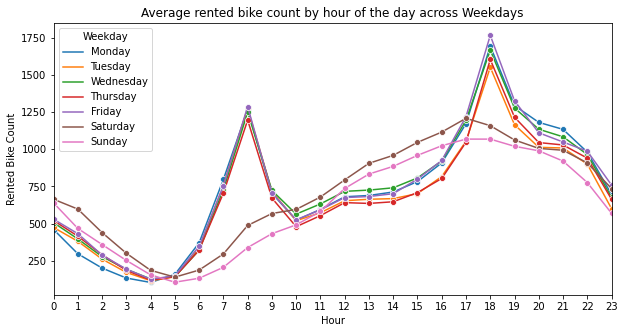

In [ ]:
#@title Bike distribution across days of week { display-mode: "form" }
#plot how count changes based on weekday using seaborn
from matplotlib.axis import Axis
import matplotlib.ticker as ticker 
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
g = sns.lineplot(x="Hour", y="Rented Bike Count", data=df, hue='Weekday', ci=None, marker='o')
g.set(xlim=(0, 23))
ax.xaxis.set_major_locator(ticker.MultipleLocator(1)) 
plt.title("Average rented bike count by hour of the day across Weekdays")
plt.savefig('weekday_line.png', dpi=300, bbox_inches='tight')

**Analysis:** *Bike rental distribution on weekdays is different from weekends*

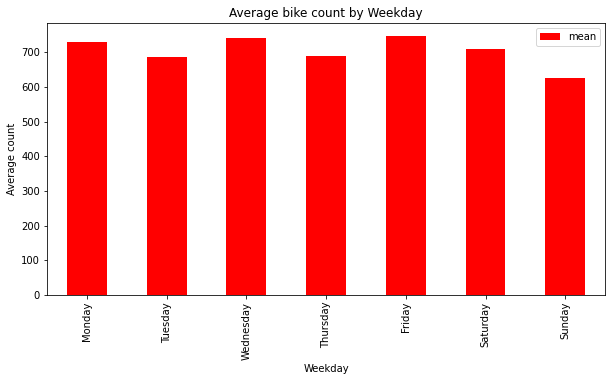

In [ ]:
#@title Average Bike count across day of week { display-mode: "form" }
#plot bar graph on how bike count changes based on month, maximum during june
month = df.groupby(['Weekday'])["Rented Bike Count"].agg(['mean'])
month.head()
month.plot.bar(y='mean', color='red', figsize=(10, 5))
plt.ylabel("Average count")
plt.title("Average bike count by Weekday")
plt.legend(['mean'], loc='upper right')
plt.savefig('weekday_bar.png', dpi=300, bbox_inches='tight')

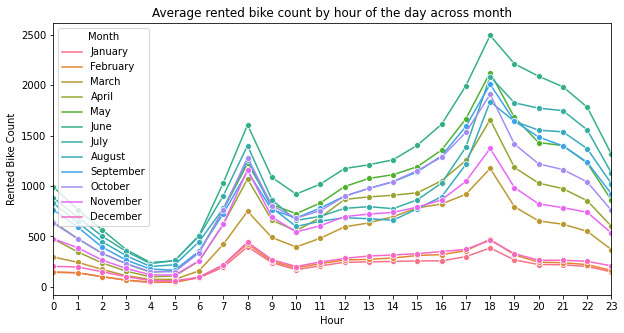

In [ ]:
#@title Bike distribution across months of an year { display-mode: "form" }
#plot how count changes based on month using seaborn
from matplotlib.axis import Axis
import matplotlib.ticker as ticker 
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
g = sns.lineplot(x="Hour", y="Rented Bike Count", data=df, hue='Month', ci=None, marker='o')
g.set(xlim=(0, 23))
ax.xaxis.set_major_locator(ticker.MultipleLocator(1)) 
plt.title("Average rented bike count by hour of the day across month")
plt.savefig('month_line.png', dpi=300, bbox_inches='tight')

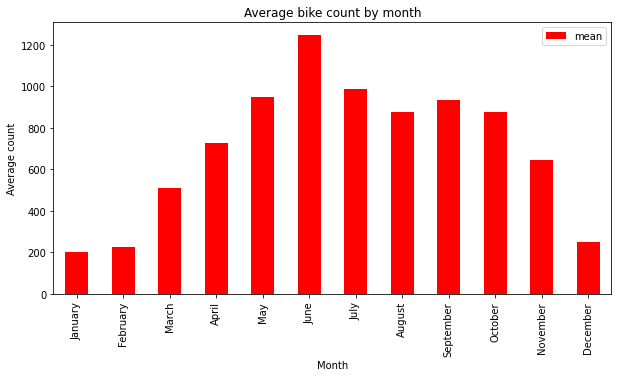

In [ ]:
#@title Average bike count across months of an year { display-mode: "form" }
#plot bar graph on how bike count changes based on month, maximum during june
month = df.groupby(['Month'])["Rented Bike Count"].agg(['mean'])
month.head()
month.plot.bar(y='mean', color='red', figsize=(10, 5))
plt.ylabel("Average count")
plt.title("Average bike count by month")
plt.savefig('month_bar.png', dpi=300, bbox_inches='tight')

**Analysis:** *Bike rental count is highest during June*

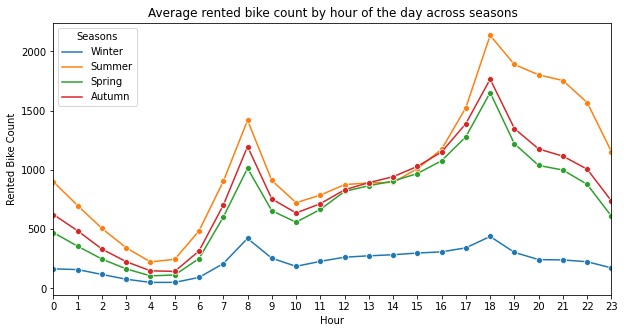

In [ ]:
#@title Bike count distribution across seasons { display-mode: "form" }
#plot how count changes based on season using seaborn
from matplotlib.axis import Axis
import matplotlib.ticker as ticker 
fig, ax = plt.subplots(1, 1, figsize=(10,5))
g = sns.lineplot(x="Hour", y="Rented Bike Count", data=df, hue='Seasons', ci=None, marker='o')
g.set(xlim=(0, 23))
ax.xaxis.set_major_locator(ticker.MultipleLocator(1)) 
plt.title("Average rented bike count by hour of the day across seasons")
plt.savefig('weather.png', dpi=300, bbox_inches='tight')

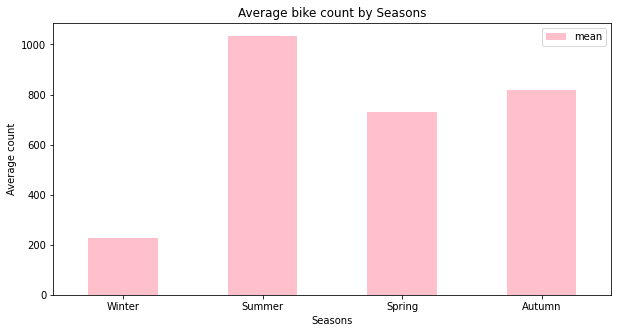

In [ ]:
#@title Average Bike count across seasons { display-mode: "form" }
#plot bar graph on how bike count changes based on month, maximum during june
month = df.groupby(['Seasons'])["Rented Bike Count"].agg(['mean'])
month.head()
month.plot.bar(y='mean', color='pink', figsize=(10, 5), rot=0)
plt.ylabel("Average count")
plt.title("Average bike count by Seasons")
plt.savefig('season_bar.png', dpi=300, bbox_inches='tight')

**Analysis**: *Summer has highest Bike rental count and Winter has lowest bike rental count*


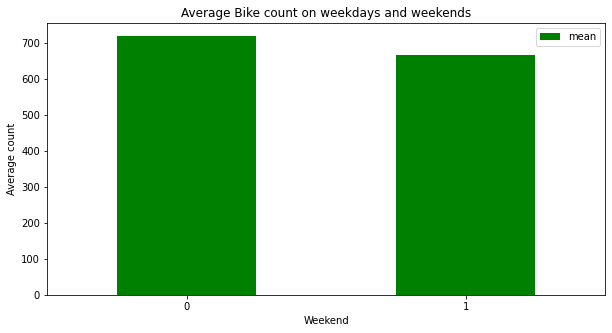

In [ ]:
#@title Average Bike count on weekdays and weekends { display-mode: "form" }
#plot bar graph on how bike count changes based on month, maximum during june
month = df.groupby(['Weekend'])["Rented Bike Count"].agg(['mean'])
month.head()
month.plot.bar(y='mean', color='green', figsize=(10, 5), rot=0)
plt.ylabel("Average count")
plt.title("Average Bike count on weekdays and weekends")
plt.savefig('Weekend.png', dpi=300, bbox_inches='tight')

**Analysis:** *Weekdays more bikes are rented on an average*

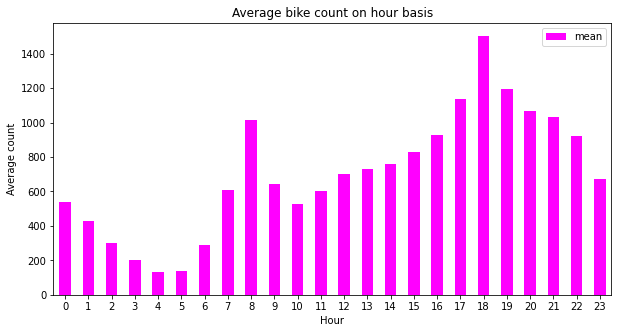

In [ ]:
#@title Average bike count distribution based on hour { display-mode: "form" }
#plot bar graph on how bike count changes based on month, maximum during june
month = df.groupby(['Hour'])["Rented Bike Count"].agg(['mean'])
month.head()
month.plot.bar(y='mean', color='magenta', figsize=(10, 5), rot=0)
plt.ylabel("Average count")
plt.title("Average bike count on hour basis")
plt.savefig('hour.png', dpi=300, bbox_inches='tight')

**Analysis:** *Rental count depends on hour, we can see linear increase, decrease with peak at 6.00PM*

*The average count is very low from 12 AM to 6 AM*

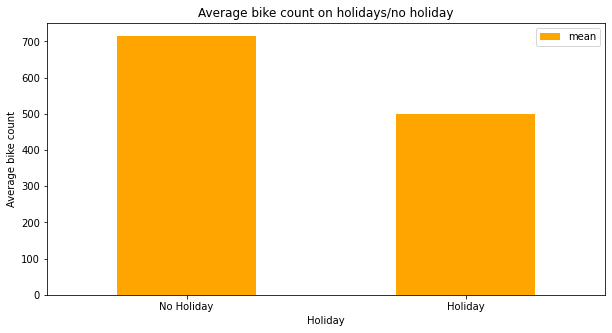

In [ ]:
#@title Average Bike distribution during Holidays/No Holidays { display-mode: "form" }
#plot bar graph on how bike count changes based on month, maximum during june
month = df.groupby(['Holiday'])["Rented Bike Count"].agg(['mean'])
month.head()
month.plot.bar(y='mean', color='orange', figsize=(10, 5), rot=0)
plt.ylabel("Average bike count")
plt.title("Average bike count on holidays/no holiday")
plt.savefig('holiday.png', dpi=300, bbox_inches='tight')

**Analysis:** *Average bike rental way lesser during holiday*

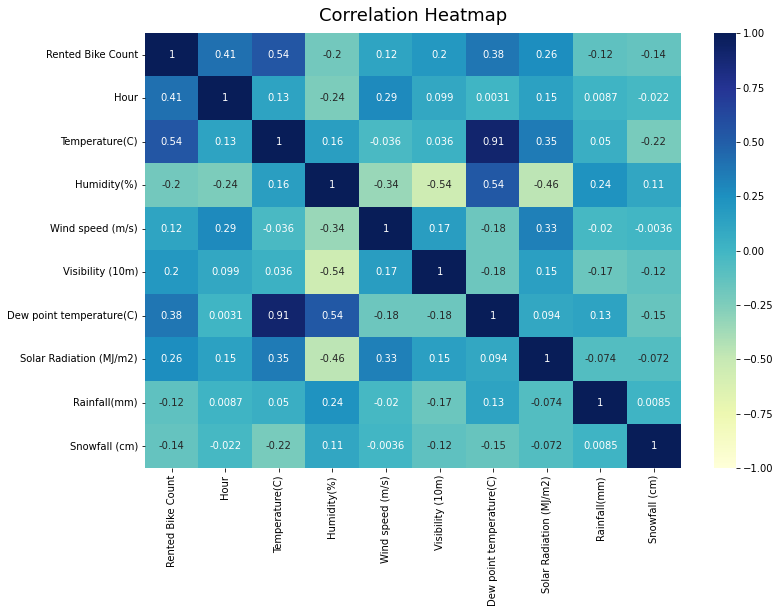

In [ ]:
#@title Correlation heat map  { display-mode: "form" }
plt.figure(figsize=(12, 8))
heatmap = sns.heatmap(Obikedata.corr(), vmin=-1, vmax=1, cmap="YlGnBu", annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12)
plt.savefig('heatmap.png', dpi=300, bbox_inches='tight')

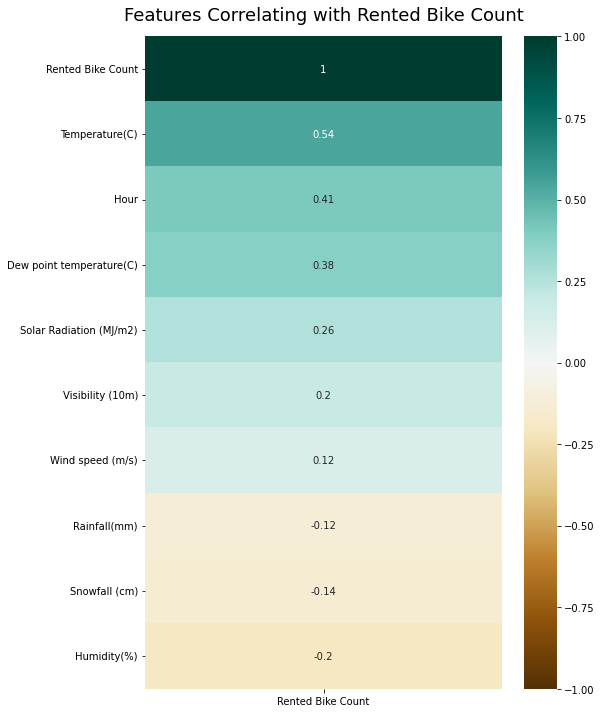

In [ ]:
#@title Features correlating with Rented Bike count { display-mode: "form" }
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(Obikedata.corr()[['Rented Bike Count']].sort_values(by='Rented Bike Count', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Features Correlating with Rented Bike Count', fontdict={'fontsize':18}, pad=16);
plt.savefig('heatmapBike.png', dpi=300, bbox_inches='tight')

**Analysis:** *Temperature, Hour highly correlate to Rented bike count*

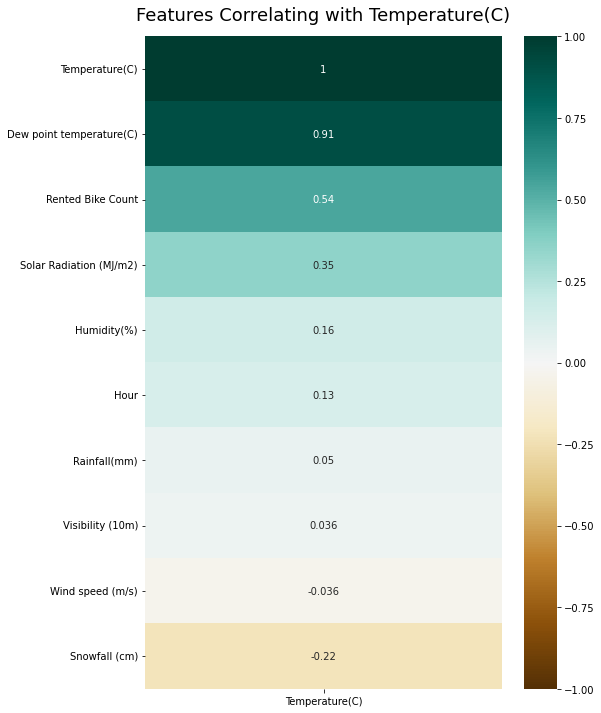

In [ ]:
#@title Features correlating with temperature { display-mode: "form" }
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(Obikedata.corr()[['Temperature(C)']].sort_values(by='Temperature(C)', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Features Correlating with Temperature(C)', fontdict={'fontsize':18}, pad=16);
plt.savefig('heatmapTemp.png', dpi=300, bbox_inches='tight')

**Analysis:** *Dew point temperature, solar radiation positively and highly  correlated, snowfall is negatively correlated
to Dew point temperature*


**Stratification**

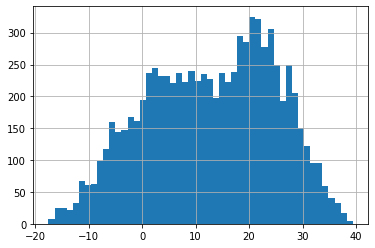

In [ ]:
#@title Stratified sampling based on temperature { display-mode: "form" }
#cannot do stratified sampling with temperature as it has NULL rows, so either I drop those rows while sampling or impute, but imputation should be done only after split
df["Temperature(C)"].hist(bins=50)
df["Temperature(C)"].describe()
mybikedata = Obikedata.copy()
mybikedata.dropna(inplace=True)
mybikedata["Temp_cat"] = pd.cut(Obikedata["Temperature(C)"],bins=[-20, 0, 10, 20, 30, np.inf ], labels=[1,2,3,4,5])
mybikedata["Temp_cat"].value_counts()
df_train, df_test = train_test_split(mybikedata,test_size=0.2,random_state=42)
df_train_strat, df_test_strat = train_test_split(mybikedata, test_size=0.2, random_state=42, stratify=mybikedata["Temp_cat"])

In [ ]:
#@title Stratified sampling and Random sampling Error distribution for temperature { display-mode: "form" }
def Temp_cat_proportions(mydata):
  return mydata["Temp_cat"].value_counts() / len(mydata)

compare_props_train = pd.DataFrame({
    "Overall": Temp_cat_proportions(mybikedata),
    "Stratified": Temp_cat_proportions(df_train_strat),
    "Random": Temp_cat_proportions(df_train),
}).sort_index()
compare_props_train["Rand. %error"] = 100 * compare_props_train["Random"] / compare_props_train["Overall"] - 100
compare_props_train["Strat. %error"] = 100 * compare_props_train["Stratified"] / compare_props_train["Overall"] - 100
compare_props_train

,Overall,Stratified,Random,Rand. %error,Strat. %error
1,0.166828,0.166768,0.168584,1.052250,-0.036284
2,0.244189,0.244249,0.241374,-1.152702,0.024789
3,0.256901,0.256961,0.259231,0.907163,0.023563
4,0.273002,0.273002,0.270430,-0.942350,0.000000
5,0.059080,0.059019,0.060381,2.202869,-0.102459


**Analysis:** *Stratification helps as error is lesser in case of stratified data, but as temperature has missing values, better not to use it for stratification*

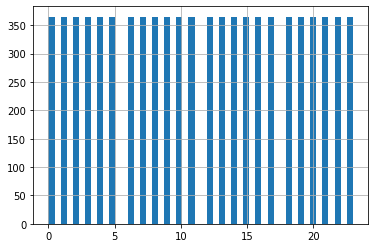

In [ ]:
#@title Stratified sampling based on hour { display-mode: "form" }
df["Hour"].hist(bins=50)
df["Hour"].describe()
stratbikedata = Obikedata.copy()
stratbikedata["hour_cat"] = pd.cut(stratbikedata["Hour"],bins=[-1, 6, 12, 18, 23], labels=[1,2,3,4]) #when min was given as 0, issue, 0 was classified as Nan
stratbikedata["hour_cat"].value_counts()
df_train, df_test = train_test_split(stratbikedata,test_size=0.2,random_state=42)
df_train_strat, df_test_strat = train_test_split(stratbikedata, test_size=0.2, random_state=42, stratify=stratbikedata["hour_cat"])
bikedata = df_train_strat.copy()

In [ ]:
#@title Stratified sampling and Random sampling Error distribution for hour { display-mode: "form" }
def hour_cat_proportions(data):
    return data['hour_cat'].value_counts() / len(data)
compare_props_train = pd.DataFrame({
    "Overall": hour_cat_proportions(stratbikedata),
    "Stratified": hour_cat_proportions(df_train_strat),
    "Random": hour_cat_proportions(df_train),
}).sort_index()
compare_props_train["Rand. %error"] = 100 * compare_props_train["Random"] / compare_props_train["Overall"] - 100
compare_props_train["Strat. %error"] = 100 * compare_props_train["Stratified"] / compare_props_train["Overall"] - 100
compare_props_train

,Overall,Stratified,Random,Rand. %error,Strat. %error
1,0.291667,0.291667,0.29024,-0.489237,0.0
2,0.250000,0.250000,0.25214,0.856164,0.0
3,0.250000,0.250000,0.25000,0.000000,0.0
4,0.208333,0.208333,0.20762,-0.342466,0.0


**Analysis:** *Stratification would greatly help based on hour as error is zero for stratified data*

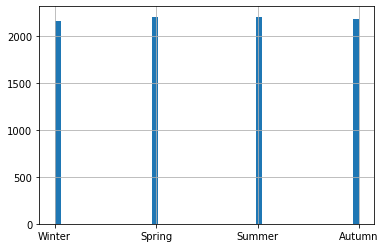

In [ ]:
#@title  Stratified sampling based on Seasons { display-mode: "form" }
df["Seasons"].describe()
df["Seasons"].hist(bins=50)
weatherbikedata = Obikedata.copy()
df_train, df_test = train_test_split(weatherbikedata,test_size=0.2,random_state=42)
df_train_strat, df_test_strat = train_test_split(weatherbikedata, test_size=0.2, random_state=42, stratify=stratbikedata["Seasons"])
bikedata = df_train_strat.copy()

In [ ]:
#@title Stratified sampling and Random sampling Error distribution for Seasons { display-mode: "form" }
def hour_cat_proportions(data):
    return data['Seasons'].value_counts() / len(data)
compare_props_train = pd.DataFrame({
    "Overall": hour_cat_proportions(weatherbikedata),
    "Stratified": hour_cat_proportions(df_train_strat),
    "Random": hour_cat_proportions(df_train),
}).sort_index()
compare_props_train["Rand. %error"] = 100 * compare_props_train["Random"] / compare_props_train["Overall"] - 100
compare_props_train["Strat. %error"] = 100 * compare_props_train["Stratified"] / compare_props_train["Overall"] - 100
compare_props_train

,Overall,Stratified,Random,Rand. %error,Strat. %error
Winter,0.246575,0.246575,0.244150,-0.983796,0.000000
Summer,0.252055,0.252140,0.250285,-0.701993,0.033967
Spring,0.252055,0.251998,0.255422,1.336051,-0.022645
Autumn,0.249315,0.249287,0.250143,0.331960,-0.011447


**Analysis:** *Stratification based on seasons would help as error is less for stratified data*

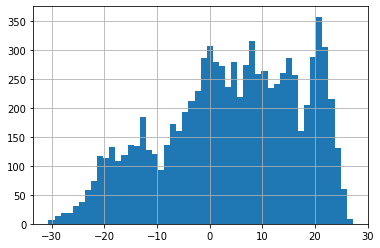

In [ ]:
#@title Stratified sampling based on Dew point temperature { display-mode: "form" }
df["Dew point temperature(C)"].hist(bins=50)
df["Dew point temperature(C)"].describe()
DTbikedata = Obikedata.copy()
DTbikedata["DTemp_cat"] = pd.cut(DTbikedata["Dew point temperature(C)"],bins=[-40, -10, 0, 10, 20, np.inf], labels=[1,2,3,4,5]) #when min was given as 0, issue, 0 was classified as Nan
DTbikedata["DTemp_cat"].value_counts()
df_train, df_test = train_test_split(DTbikedata,test_size=0.2,random_state=42)
df_train_strat, df_test_strat = train_test_split(DTbikedata, test_size=0.2, random_state=42, stratify=DTbikedata["DTemp_cat"])

In [ ]:
#@title Stratified sampling and Random sampling Error distribution for Dew point temperature { display-mode: "form" }
def DTemp_cat_proportions(data):
  return data["DTemp_cat"].value_counts() / len(data)

compare_props_train = pd.DataFrame({
    "Overall": DTemp_cat_proportions(DTbikedata),
    "Stratified": DTemp_cat_proportions(df_train_strat),
    "Random": DTemp_cat_proportions(df_train),
}).sort_index()
compare_props_train["Rand. %error"] = 100 * compare_props_train["Random"] / compare_props_train["Overall"] - 100
compare_props_train["Strat. %error"] = 100 * compare_props_train["Stratified"] / compare_props_train["Overall"] - 100
compare_props_train

,Overall,Stratified,Random,Rand. %error,Strat. %error
1,0.173402,0.173373,0.170805,-1.497696,-0.016458
2,0.191667,0.191638,0.192066,0.208457,-0.014890
3,0.266553,0.266553,0.272546,2.248394,0.000000
4,0.237329,0.237300,0.234304,-1.274651,-0.012025
5,0.131050,0.131136,0.130280,-0.587979,0.065331


**Analysis:** *Stratification helps as error is lesser in case of stratified data, we can use this feature also for stratified sampling*

**Whether stratification based on seasons helps? lets check with simple imputer, linear regression**

In [ ]:
#@title Data preparation { display-mode: "form" }
bml = bikedata.drop("Rented Bike Count", axis=1) # drop labels for training set
bml_labels = bikedata["Rented Bike Count"].copy() 

In [ ]:
#@title Build a pipeline with simple imputer, standard scalar, onehotencoder { display-mode: "form" }
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

num_pipeline = Pipeline([
                         ('imputer',SimpleImputer(strategy="median")),
                         ('scaler',StandardScaler())
                         ])

cat_pipeline = Pipeline([
                         ('encoder',OneHotEncoder())
                         ])

from sklearn.compose import ColumnTransformer

cat_cols = [0, 1, 10, 11,12]
bml_num = bml.drop(bml.columns[cat_cols], axis=1)
num_cols = list(bml_num) # Alternatively: bml_num.columns.values.tolist()

full_pipeline = ColumnTransformer([
                                   ('num',num_pipeline,num_cols),
                                   ('cat',cat_pipeline,cat_cols)
                                   ])

bml_prepared = full_pipeline.fit_transform(bml)

In [ ]:
#@title Fit using Linear regression { display-mode: "form" }
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()

lin_reg.fit(bml_prepared,bml_labels)

LinearRegression()

In [ ]:
#@title Evaluate using RMSE, R2 { display-mode: "form" }
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
bml_test = df_test_strat.drop("Rented Bike Count", axis=1) # drop labels for training set
bml_test_labels = df_test_strat["Rented Bike Count"].copy() 
X_test = full_pipeline.transform(bml_test)
y_test_predict = lin_reg.predict(X_test)
MSE = mean_squared_error(bml_test_labels,y_test_predict,squared=False)
R2 = r2_score(bml_test_labels,y_test_predict,multioutput='variance_weighted')
print("RMSE = " +str(MSE)+ "\nR2 =", str(R2) )

RMSE = 317.7401682663817
R2 = 0.7607011578294566


Without stratification: RMSE: 326.95, R2: 0.743

**Analysis:** *Based on above results we see improvement in accuracy when season based stratified test data is used in comparision to 326 RMSE without stratification*

#Polynomial Regression

In [ ]:
#@title Common functions for polynomial regression { display-mode: "form" }
def prepareData(data):
  X = data.copy()
  X['Seasons'].replace(['Summer', 'Spring', 'Autumn', 'Winter'], [0, 1, 2, 3], inplace=True)
  X["Seasons_sin"] = np.sin(2 * np.pi * X['Seasons']/3.0)
  X['Date'] =  pd.to_datetime(X['Date'])
  X["Month"] = np.sin(2 * np.pi * X['Date'].dt.month/12.0)
  X['Day'] =  np.sin(2 * np.pi * X['Date'].dt.dayofweek/6.0)
  X['Hour_sin'] = np.sin(2 * np.pi * X['Hour']/23.0)
  X['Hour_cos'] = np.cos(2 * np.pi * X['Hour']/23.0)
  X = X.drop(['Date'], axis=1)
  X = X.drop(['Hour'], axis=1)
  X = X.drop(['Seasons'], axis=1)
  return X

def getImputedNumericCols(data):
  df_num = data.drop(['Holiday', 'Functioning Day'], axis=1)
  X_train_num = df_num.bfill()
  return pd.DataFrame(data=X_train_num,columns=df_num.columns,index=df_num.index)

def getKnImputedNumericCols(data):
  # Use only the rows with temperature value for building the model
  dfWithoutTemp = data.loc[df['Temperature(C)'].notnull()]
  # Keep the rows without Temperature value for prediction using the model created
  dfPrediction = data.loc[df['Temperature(C)'].isna()]
  xparams = ["Dew point temperature(C)", "Solar Radiation (MJ/m2)", "Snowfall (cm)", "Humidity(%)", "Rainfall(mm)",  "Hour_sin", "Hour_cos"]
  lin_reg, RMSE, R2 = performKNN(dfWithoutTemp, xparams)
  #Predicting Missing Values
  #X, y = prepareData(dfPrediction)
  actualX = dfPrediction[xparams]
  actual_missing_temp_predict = lin_reg.predict(actualX)
  dfPrediction["Temperature(C)"] = actual_missing_temp_predict
  df_new = pd.concat([dfWithoutTemp, dfPrediction])
  return df_new

from sklearn.preprocessing import PolynomialFeatures
def polynomiseData(df, df_num):
  poly_features = PolynomialFeatures(degree=2, include_bias=False)
  np_num_poly = poly_features.fit_transform(df_num.drop(['Rented Bike Count'], axis=1))
  poly_cols = poly_features.get_feature_names(df_num.drop(['Rented Bike Count'], axis=1).columns)
  df_num_poly = pd.DataFrame(data=np_num_poly,columns=poly_cols,index=df_num.drop(['Rented Bike Count'], axis=1).index)
  df_num_poly_with_target = pd.concat([df_num_poly,df_num['Rented Bike Count']],axis=1)
  df_poly = pd.concat([df_num_poly,df['Holiday'],df['Functioning Day']],axis=1)
  return df_poly, df_num_poly_with_target

def performKNN(dfWithoutTemp, xcols):
  #X, y = prepareData(dfWithoutTemp)
  print("performKNN")
  Xtem = dfWithoutTemp[xcols]
  ytem = dfWithoutTemp['Temperature(C)']

  X_trainT, X_testT, y_trainT, y_testT = train_test_split(Xtem, ytem, test_size= 0.2, random_state=42)
  lin_reg = KNeighborsRegressor()
  lin_reg.fit(X_trainT,y_trainT)
  y_test_predict = lin_reg.predict(X_testT)

  RMSE = mean_squared_error(y_testT,y_test_predict,squared=False)

  R2 = r2_score(y_testT,y_test_predict,multioutput='variance_weighted')

  print("Imputer Model KNN \nRMSE = " +str(RMSE)+ "\nR2 =", str(R2) )

  return lin_reg, RMSE, R2

In [ ]:
#@title Split and Prepare data  { display-mode: "form" }
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(Obikedata,test_size=0.2,random_state=42)

prepared_data_train = prepareData(df_train)
prepared_data_test = prepareData(df_test)


df_train_num = getImputedNumericCols(prepared_data_train)
df_test_num = getImputedNumericCols(prepared_data_test)

prepared_data_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7008 entries, 8415 to 7270
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   Rented Bike Count         7008 non-null   int64   
 1   Temperature(C)            6611 non-null   float64 
 2   Humidity(%)               7008 non-null   int64   
 3   Wind speed (m/s)          7008 non-null   float64 
 4   Visibility (10m)          7008 non-null   int64   
 5   Dew point temperature(C)  7008 non-null   float64 
 6   Solar Radiation (MJ/m2)   7008 non-null   float64 
 7   Rainfall(mm)              7008 non-null   float64 
 8   Snowfall (cm)             7008 non-null   float64 
 9   Holiday                   7008 non-null   category
 10  Functioning Day           7008 non-null   category
 11  Seasons_sin               7008 non-null   float64 
 12  Month                     7008 non-null   float64 
 13  Day                       7008 non-null   flo

##Polynomial Features

In [ ]:
#@title Generate Polynomial Features { display-mode: "form" }
df_train_poly, df_train_num_poly_with_target = polynomiseData(prepared_data_train, df_train_num)
df_test_poly, df_test_num_poly_with_target = polynomiseData(prepared_data_test, df_test_num)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


##Polynomial Features (EDA)

In [ ]:
#@title Check correlation of polynomial features { display-mode: "form" }
corr_mat = df_train_num_poly_with_target.corr()#how the features are corelated
corr_mat["Rented Bike Count"].abs().sort_values(ascending=False)
corr_mat[corr_mat["Rented Bike Count"].abs() > 0.05]["Rented Bike Count"].abs().sort_values(ascending=False)

Rented Bike Count                  1.000000
Temperature(C) Visibility (10m)    0.529875
Temperature(C)                     0.510307
Temperature(C) Wind speed (m/s)    0.501269
Temperature(C) Hour_sin            0.461674
                                     ...   
Temperature(C) Snowfall (cm)       0.065093
Month Hour_cos                     0.063014
Seasons_sin                        0.055854
Rainfall(mm)^2                     0.052829
Visibility (10m) Seasons_sin       0.050211
Name: Rented Bike Count, Length: 67, dtype: float64

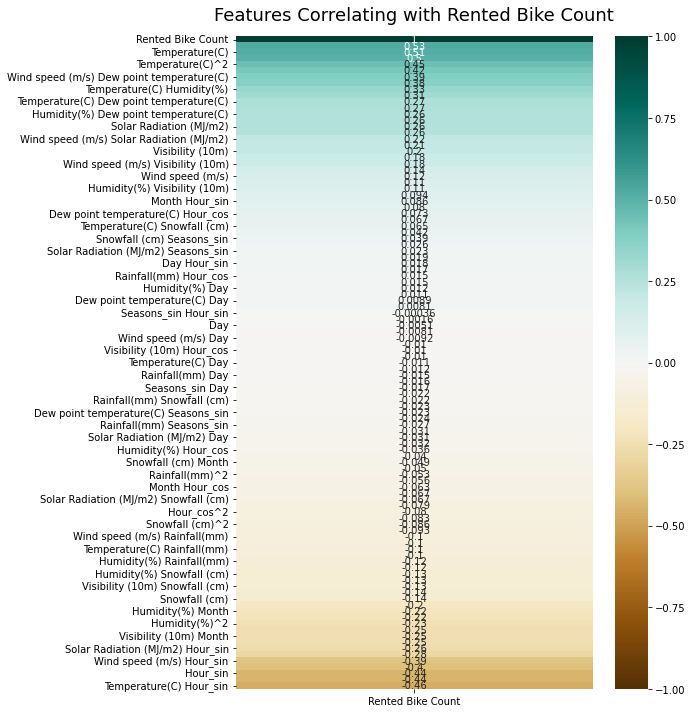

In [ ]:
#@title Check correlation by plotting heat map { display-mode: "form" }
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(df_train_num_poly_with_target.corr()[['Rented Bike Count']].sort_values(by='Rented Bike Count', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Features Correlating with Rented Bike Count', fontdict={'fontsize':18}, pad=16);
plt.savefig('heatmapBikepoly.png', dpi=300, bbox_inches='tight')

**Analysis:** *The above graph shows all polynomial features and its correlation with rented bike count some of highly correlated features are Temperature(C) & Wind speed (m/s), Temperature(C) & Visibility, Temperature(C) & Hour_sin*


##Build Model & Evaluate Model

In [ ]:
#@title Create pipeline and fit { display-mode: "form" }
def buildModelAndEvaluate(model,modelName,df_train_num,df_train_prepared,df_test_prepared,df_train,df_test):
  num_pipeline = Pipeline([('scaler',StandardScaler())])
  cat_pipeline = Pipeline([('encoder',OneHotEncoder())])

  cat_cols = ['Holiday','Functioning Day']
  num_cols = [col for col in list(df_train_num) if col not in cat_cols]

  full_pipeline = ColumnTransformer([('num', num_pipeline, num_cols),
                                  ('cat', cat_pipeline, cat_cols)])

  #Data preparation
  X_train_prepared = full_pipeline.fit_transform(df_train_prepared)
  X_test_prepared = full_pipeline.transform(df_test_prepared)

  #Model Fitting
  from sklearn.linear_model import LinearRegression

  model.fit(X_train_prepared, df_train['Rented Bike Count'])

  #Evaluation
  y_test_predict = model.predict(X_test_prepared)
  MSE = mean_squared_error(df_test['Rented Bike Count'], y_test_predict, squared=False)
  R2 = r2_score(df_test['Rented Bike Count'],y_test_predict, multioutput='variance_weighted')
  print("Model : " + modelName +",  RMSE = " +str(MSE)+ ", R2 =", str(R2))

In [ ]:
#@title Evaluate with polynomial features { display-mode: "form" }
lin_reg = LinearRegression()
xgb_r = xg.XGBRegressor(n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8)
knr = KNeighborsRegressor()
models = {'LinearRegression': lin_reg, 'KNeighborsRegressor': knr, 'XgBoost': xgb_r}
df_train_num = df_train_num_poly_with_target.drop(['Rented Bike Count'],axis=1)
df_train_prepared = df_train_poly
df_test_prepared = df_test_poly
for key in models:
  buildModelAndEvaluate(models[key],key,df_train_num,df_train_prepared,df_test_prepared,df_train,df_test)

Model : LinearRegression,  RMSE = 345.49078712713316, R2 = 0.7135126320923244
Model : KNeighborsRegressor,  RMSE = 322.47936591099307, R2 = 0.7504047030153942
[10:53:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Model : XgBoost,  RMSE = 230.6886222994091, R2 = 0.8722723604775715


**Analysis:** *Based on above results we see polynomial regression is not helping in improving accuracy hence its not useful for this problem statement*